In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA





In [2]:
class AnnoyIndex():
    def __init__(self, vectors, labels, metric):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
        self.metric= metric
   
    def build(self, number_of_trees=100):
        self.index = annoy.AnnoyIndex(self.dimension, self.metric)
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=1000):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=-1)                                           
        return [self.labels[i] for i in indices]
    
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         'feature_linear_trend_magn_r',
                         'feature_linear_trend_sigma_magn_r',
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         'feature_period_s_to_n_0_magn_r',
                         #'feature_period_1_magn_r', 
                         'feature_period_s_to_n_1_magn_r',
                         #'feature_period_2_magn_r', 
                         'feature_period_s_to_n_2_magn_r',
                         #'feature_period_3_magn_r', 
                         'feature_period_s_to_n_3_magn_r',
                         #'feature_period_4_magn_r', 
                         'feature_period_s_to_n_4_magn_r',
                         #'feature_periodogram_amplitude_magn_r',
                         'feature_periodogram_beyond_2_std_magn_r',
                         'feature_periodogram_beyond_3_std_magn_r',
                         'feature_periodogram_standard_deviation_magn_r', 
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         'feature_linear_trend_magn_g',
                         'feature_linear_trend_sigma_magn_g',
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         'feature_period_s_to_n_0_magn_g',
                         #'feature_period_1_magn_g', 
                         'feature_period_s_to_n_1_magn_g',
                         #'feature_period_2_magn_g', 
                         'feature_period_s_to_n_2_magn_g',
                         #'feature_period_3_magn_g', 
                         'feature_period_s_to_n_3_magn_g',
                         #'feature_period_4_magn_g', 
                         'feature_period_s_to_n_4_magn_g',
                         #'feature_periodogram_amplitude_magn_g',
                         'feature_periodogram_beyond_2_std_magn_g',
                         'feature_periodogram_beyond_3_std_magn_g',
                         'feature_periodogram_standard_deviation_magn_g', 
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']

In [3]:
dataset_bank = pd.read_csv('../loci_dbs/loci_df_271688objects_cut_stars_and_gal_plane_transf.csv', 
                                   compression='gzip',
                                   usecols=lambda c: c in ztf_id_and_features_r_g,
                                  index_col='ztf_object_id')
        
# drop row if any feature values are nan
dataset_bank = dataset_bank[~dataset_bank[feature_names_r_g].isnull().any(axis=1)]

#mask = (dataset_bank['num_mag_values'] >= 40) #& (dataset_bank['num_mag_values'] <= 40)
#dataset_bank = dataset_bank[mask]
dataset_bank

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (7,125,129,130,131,132,133,134) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,locus_id,ra,dec,tags,catalogs,ztf_ssnamenr,num_alerts,num_mag_values,oldest_alert_id,...,anom_score,anomaly_score,anomaly_mask,anomaly_type,is_corrected,vpdf_extreme_version,vpdf_extreme_faint,vpdf_extreme_bright,locus_gal_l,locus_gal_b
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,6,ANT2020rajqu,33.976088,-20.258905,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,137,35,ztf_candidate:993481181415010007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197.881532,-69.513571
ZTF18acfvwwa,39,ANT2020pc6ko,35.639509,32.833982,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,659,88,ztf_candidate:943483942915015010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.200342,-26.246909
ZTF17aaaskvj,58,ANT2020rdpmm,28.015003,36.953217,['lc_feature_extractor'],"['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...",NaN,1497,579,ztf_candidate:598425334815010002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.189482,-24.352953
ZTF17aaaskvj,59,ANT2018ftblk,28.015003,36.953216,"['lc_feature_extractor', 'high_snr']","['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...",NaN,1504,583,ztf_candidate:598425334815010002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.189482,-24.352954
ZTF18aczbnhl,97,ANT2019dsk24,85.049145,-11.013302,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,105,12,ztf_candidate:718232301815010005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214.961559,-20.751422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aberawv,999927,ANT2020aebbk,292.910293,54.078978,"['lc_feature_extractor', 'dimmers']",[],NaN,235,96,ztf_candidate:1231482062015010023,...,NaN,0.417276,Fail,TBD,NaN,NaN,NaN,NaN,85.961850,16.149525
ZTF18acrvsjf,999938,ANT2019zf6fg,72.820139,1.073984,['lc_feature_extractor'],"['allwise', 'bright_guide_star_cat', '2mass_ps...",NaN,40,14,ztf_candidate:696399341515010050,...,NaN,NaN,NaN,TBD,NaN,NaN,NaN,NaN,197.132900,-25.906137
ZTF18acdqrna,999957,ANT2020aefhrvi,53.476865,77.496741,['lc_feature_extractor'],"['allwise', 'bright_guide_star_cat', '2mass_ps...",NaN,83,36,ztf_candidate:1353408024115015003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.425108,17.392307


In [4]:
# only keep features of bank
dataset_bank_orig = dataset_bank[feature_names_r_g]
dataset_bank_orig

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,feature_standard_deviation_magn_g,feature_stetson_k_magn_g,feature_weighted_mean_magn_g,feature_anderson_darling_normal_flux_g,feature_cusum_flux_g,feature_excess_variance_flux_g,feature_kurtosis_flux_g,feature_mean_variance_flux_g,feature_skew_flux_g,feature_stetson_k_flux_g
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.514069,-0.037026,0.230769,0.277350,0.210596,1.028137,0.606000,0.224944,2.176230,-0.001783,...,0.344664,0.833143,18.288298,-0.741267,0.244416,0.409971,-0.783581,-0.535533,-0.061333,0.815809
ZTF18acfvwwa,0.593122,-0.303523,0.303030,0.246183,0.272132,1.152622,0.729088,0.356500,0.552720,0.000145,...,0.255341,0.796845,17.025929,0.013852,0.276394,0.369215,0.319612,-0.616276,0.720649,0.746565
ZTF17aaaskvj,1.325100,0.305955,0.310345,0.194759,0.069613,1.452066,0.900613,0.490911,1.562089,-0.000205,...,0.384571,0.542215,16.768612,1.073154,0.119285,0.611570,4.490889,-0.309191,2.390988,0.613781
ZTF17aaaskvj,1.325100,0.300439,0.308219,0.194091,0.072355,1.448558,0.899251,0.491846,1.551687,-0.000213,...,0.386585,0.541809,16.773018,1.066396,0.119160,0.611631,4.488470,-0.309169,2.386820,0.613769
ZTF18aczbnhl,0.276431,-0.610376,0.250000,0.000000,0.370062,0.552862,0.552862,0.316462,1.948112,-0.000285,...,0.492342,0.871093,18.629537,-0.228569,0.247441,0.547583,-1.541604,-0.365630,0.163018,0.879632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aberawv,0.300650,-0.429238,0.297297,0.232495,0.184334,0.595349,0.392779,0.242816,-0.351417,0.000136,...,0.155849,0.792311,19.806295,-0.593235,0.204807,-0.221537,-0.302184,-0.857277,-0.176622,0.787504
ZTF18acrvsjf,0.383450,-0.343338,0.166667,0.000000,0.422187,0.766899,0.732969,0.427601,-1.013720,0.013309,...,0.399852,0.863606,18.111818,-0.572841,0.379990,0.461553,-0.568062,-0.479605,-0.111461,0.810731
ZTF18acdqrna,0.371200,-0.664954,0.277778,0.000000,0.321254,0.742399,0.511758,0.323900,-0.753142,-0.001131,...,0.306282,0.747445,17.685317,-0.366746,0.267253,0.396504,1.539943,-0.555800,0.748662,0.795946


In [5]:

# https://github.com/uiucsn/laiss/blob/main/LAISS/notebooks/LAISS_tests.ipynb
idx_arr = np.hstack(np.array(dataset_bank_orig.index, dtype='object'))
feat_arr = np.vstack(np.array(dataset_bank_orig, dtype='object'))


#scaler = preprocessing.StandardScaler() # Create a scalar
scaler = preprocessing.MinMaxScaler() # Create a scalar
#scaler = preprocessing.MaxAbsScaler() # Create a scalar
#scaler = preprocessing.RobustScaler(quantile_range=(33.0, 67.0)) # quantile_range=(25.0, 75.0) good for outliers
#scaler = preprocessing.Normalizer(norm='l2') #norm='max', norm='l1',
#scaler = preprocessing.SplineTransformer(n_knots=5, degree=3, knots='uniform', 
#                                          extrapolation='constant', include_bias=True, order='C')
#scaler = preprocessing.FunctionTransformer(np.cbrt, validate=True)
#scaler = preprocessing.FunctionTransformer(np.conjugate, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)

#print("scaler")
#scaler.fit(feat_arr) # Fit only to training data
#feat_arr_scaled = scaler.transform(feat_arr) # What your model learns on
#print(np.shape(feat_arr_scaled))
#print(feat_arr_scaled)



# #OR try PCA, then scalar
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))
# scaler.fit(feat_arr_scaled) # Fit only to training data
# feat_arr_scaled = scaler.transform(feat_arr_scaled) # What your model learns on

#OR try scalar then PCA
print("pca")
# Initialize PCA with 15 principal components
n_components=25
pca = PCA(n_components=n_components)
feat_arr_scaled = scaler.fit_transform(feat_arr)
feat_arr_scaled = np.array(pca.fit_transform(feat_arr_scaled))

# # #OR try PCA only
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))

# Print the explained variance
print(np.cumsum(pca.explained_variance_ratio_))

# Build ANNOY index of scaled features of dataset_bank
index = AnnoyIndex(feat_arr_scaled, idx_arr, metric='euclidean')
index.build()
# dist metrics: dot is not good, eucl and manhattan are more or less same, 
# hamming is good distance but matches aren't as similar
# angular has best matches?

pca
[0.23039056 0.39547268 0.49004163 0.56279701 0.60597478 0.64293407
 0.6744957  0.70133184 0.72597255 0.74994114 0.7706908  0.79061063
 0.80817714 0.8234333  0.83753344 0.85101642 0.86316356 0.87477586
 0.88583139 0.89628417 0.9060682  0.91311195 0.91992921 0.92576442
 0.93115947]


# TODO: get Tns classes, do distance distr per class (in diff metrics)

In [6]:
# Scalar then PCA
col_names = [f'PC'+str(i) for i in range(n_components)]
dataset_bank_pca = pd.DataFrame(pca.fit_transform(feat_arr_scaled), columns=col_names)
dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
dataset_bank_pca

# # Just PCA
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca


# # Just PCA, then scalar
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca = scaler.transform(dataset_bank_pca)
# dataset_bank_pca = pd.DataFrame(dataset_bank_pca, columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.538141,0.148851,-0.438363,-0.093599,-0.261809,0.485150,0.035723,0.123459,0.049304,-0.180760,...,-0.061741,-0.099706,0.088888,0.110417,0.061632,-0.140906,-0.149454,0.053278,-0.050590,-0.020417
ZTF18acfvwwa,0.599408,0.223573,0.076394,0.240885,0.136615,0.360182,-0.023249,0.034717,-0.120691,-0.186074,...,-0.000541,-0.105709,0.111936,0.069446,0.045642,0.069960,-0.078071,-0.073879,0.122081,-0.019856
ZTF17aaaskvj,1.218188,0.855351,0.249786,0.255937,-0.267852,-0.225082,0.387865,0.401781,0.148523,0.136416,...,-0.105649,0.230644,-0.045422,-0.057812,-0.052772,-0.080976,0.008907,0.094828,0.257803,0.074800
ZTF17aaaskvj,1.200853,0.852557,0.249214,0.251377,-0.274088,-0.224367,0.391013,0.396215,0.156524,0.115361,...,-0.099176,0.219160,-0.045760,-0.057039,-0.046076,-0.089004,0.019541,0.099144,0.259824,0.077782
ZTF18aczbnhl,-0.348307,-0.194542,-0.443213,0.187053,-0.214084,-0.373077,-0.388558,0.205781,-0.165907,-0.141434,...,0.156824,-0.130717,-0.163214,0.147218,-0.053458,0.110482,0.096973,-0.077913,0.344238,-0.142102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aberawv,0.930267,-0.456519,0.027062,0.396545,-0.143151,0.076985,0.033647,-0.058114,-0.045080,-0.005292,...,-0.171806,-0.062068,0.010930,-0.082148,-0.004437,0.036721,-0.001366,-0.092776,0.009555,0.033160
ZTF18acrvsjf,-0.731951,-0.304998,0.282716,0.094136,0.210098,0.207501,0.139914,-0.186067,0.060418,-0.152371,...,-0.154253,0.145256,-0.054041,0.158486,-0.245874,-0.186320,-0.017635,0.027911,-0.157447,-0.087322
ZTF18acdqrna,0.262027,0.080751,0.666251,0.078619,0.027661,0.234308,-0.247695,-0.080371,-0.048387,-0.075489,...,0.047797,-0.046788,-0.075095,0.038725,-0.154467,0.000432,-0.144395,-0.137729,0.024415,0.030596


In [7]:
# Reference
# ZTF21aassamj	dataset_bank.iloc[-5:-4] is good Ia

#with PCA
dataset_bank = dataset_bank_pca.copy()


# # No PCA
# dataset_bank = dataset_bank_orig.copy()


dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aassamj'] # SN ia (lower first ANN dist), 0.3478 [eucl.], 2.1561 [manhattan], 21.8293 [dot], 0 for first 3, then 1,2... [hamming], 0.077 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwrcmq'] # SN iax ,  , 3.5786 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abuicad'] # SLSN z=0.135, , 4.449 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abqkbfx'] # Ia-CSM , , 4.0267 [manhattan], 4 is first match, then 5 [hamming]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achncvv']  # SLSN-II
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpbdvm'] # SN II , , 2.3857 [manhattan], 0.088 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acveyyv'] # SN IIn
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abktckv'] # Lensing (high first ANN dist), 0.7893, 4.5839 [manhattan], 21.5625 [dot], 8! for first one, then 9,10... [hamming], 0.1678 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achutoz'] # junk
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abtkeaf'] # star #ZTF18acdqrna #ZTF19aapunrg #ZTF18abtkeaf
dataset_ref 

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aassamj,-0.587521,0.070572,-0.126513,0.394259,0.943086,-0.21293,-0.178959,0.210465,0.176929,0.062475,...,-0.125544,-0.065491,0.023162,-0.075895,-0.003522,-0.107265,-0.13871,0.116586,-0.10981,-0.118314


In [8]:
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# Scalar then PCA
scaled_feat_arr_ref = np.array(dataset_ref)

# # PCA only
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

ztf_id = dataset_ref.index.values[0]
lcdata = {'name': ztf_id, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {ztf_id}") 
link_ref = display_markdown(f'https://alerce.online/object/{ztf_id}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

ZTF ID name (ref) ZTF21aassamj


https://alerce.online/object/ZTF21aassamj

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://alerce.online/object/ZTF21aassamj

0		90181				None			0.0


https://alerce.online/object/ZTF20acwnrty

1		17019				None			0.2339


https://alerce.online/object/ZTF20acnvlgg

2		5478				None			0.2872


https://alerce.online/object/ZTF21aanwfjk

3		46111				None			0.3016


https://alerce.online/object/ZTF21aaswvyc

4		15214				None			0.3209


https://alerce.online/object/ZTF18acybdar

5		4456				None			0.3412


https://alerce.online/object/ZTF21aavqwhh

6		82995				None			0.3437


https://alerce.online/object/ZTF21aawzsew

7		70057				None			0.3461


https://alerce.online/object/ZTF21abjeyoh

8		62841				None			0.364


https://alerce.online/object/ZTF21aapkvrd

9		8026				None			0.3879


In [9]:
results_df = dataset_bank[dataset_bank.index.isin(idx_arr[result_id])]
results_df = results_df.reindex(idx_arr[result_id])
results_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aassamj,-0.587521,0.070572,-0.126513,0.394259,0.943086,-0.212930,-0.178959,0.210465,0.176929,0.062475,...,-0.125544,-0.065491,0.023162,-0.075895,-0.003522,-0.107265,-0.138710,0.116586,-0.109810,-0.118314
ZTF20acwnrty,-0.570213,0.034169,-0.065447,0.401728,0.934496,-0.195782,-0.091707,0.226873,0.166903,0.073626,...,-0.067060,-0.115091,0.005582,-0.009201,-0.047786,-0.123200,-0.115964,0.083710,-0.096265,0.019538
ZTF20acnvlgg,-0.589578,0.112118,-0.134781,0.467056,1.039584,-0.111479,-0.150210,0.232211,0.263105,0.044815,...,-0.106355,-0.033343,-0.031127,-0.086110,-0.011866,-0.039453,-0.026757,0.075698,-0.157482,-0.079921
ZTF21aanwfjk,-0.597311,-0.019940,-0.180887,0.303186,0.896591,-0.190956,-0.093992,0.159115,0.242351,0.021442,...,-0.148382,-0.066381,0.000180,0.039943,0.057662,-0.080680,-0.114610,0.144294,-0.137161,-0.065118
ZTF21aaswvyc,-0.676021,-0.087664,-0.021890,0.445203,0.906650,-0.232044,-0.078571,0.130160,0.138213,0.068095,...,-0.052797,-0.042542,0.042463,-0.039908,0.008036,-0.075868,-0.152628,0.132114,-0.032558,-0.022682
ZTF18acybdar,-0.549718,0.042921,-0.202282,0.430677,0.896244,-0.110288,-0.137779,0.208039,0.209296,0.053679,...,-0.057658,-0.023276,-0.055530,-0.041618,-0.049878,0.025804,-0.176749,0.075036,-0.027130,-0.199218
ZTF21aavqwhh,-0.613919,-0.113277,-0.055076,0.327895,0.904119,-0.112637,-0.115731,0.181163,0.270483,0.051429,...,-0.041757,-0.051719,0.063423,-0.071583,0.065967,-0.030456,-0.111697,0.069765,-0.083211,-0.049772
ZTF21aawzsew,-0.725151,0.042928,-0.192530,0.517175,0.974893,-0.103694,-0.156921,0.282620,0.160099,-0.030958,...,-0.099074,0.039474,0.054926,0.017550,0.080260,-0.040470,-0.159244,0.096470,-0.050289,-0.157567
ZTF21abjeyoh,-0.658946,0.083789,-0.241590,0.437300,0.944343,-0.219907,-0.120674,0.251285,0.169135,-0.039792,...,-0.082187,-0.082120,-0.026031,-0.015639,-0.052800,0.057746,-0.021844,0.187007,-0.004168,-0.087231


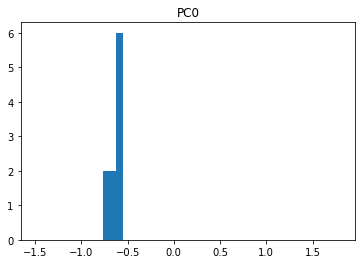

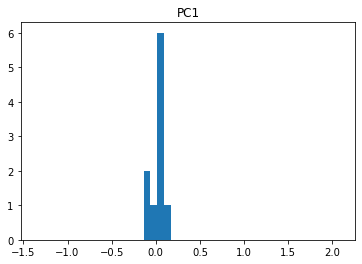

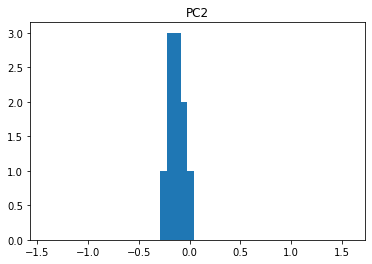

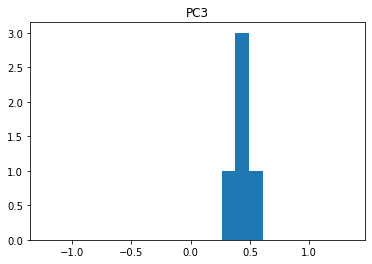

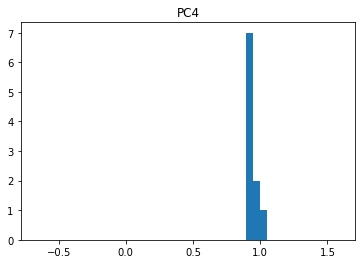

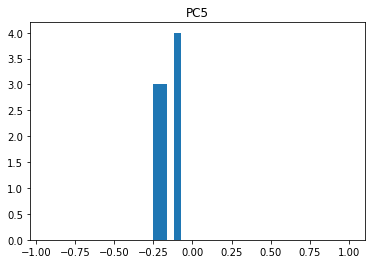

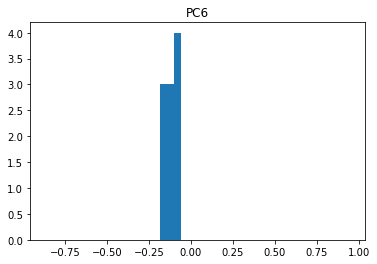

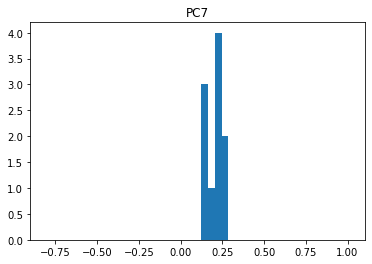

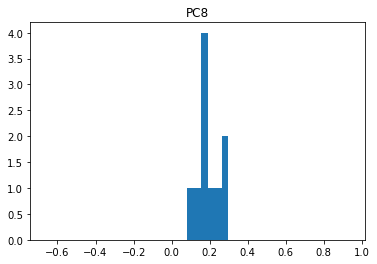

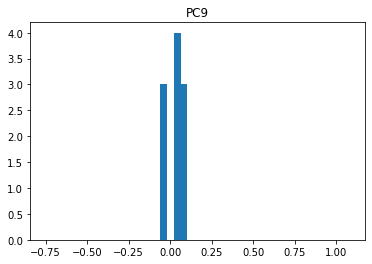

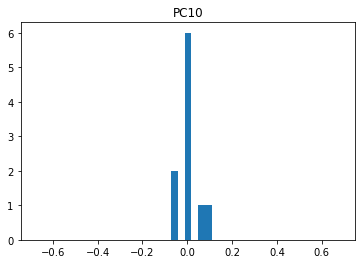

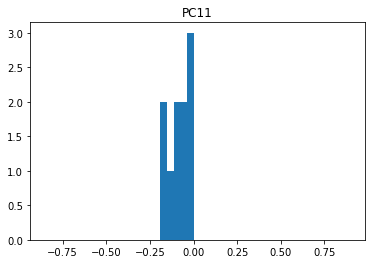

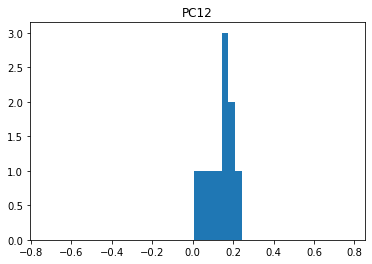

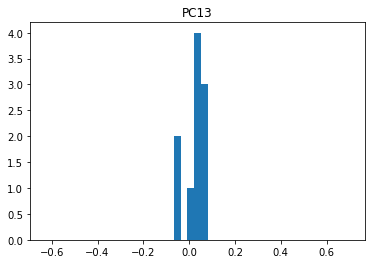

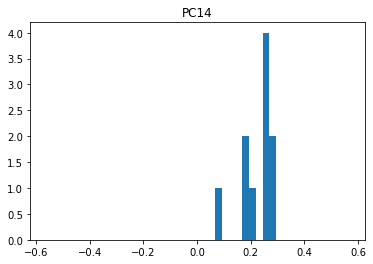

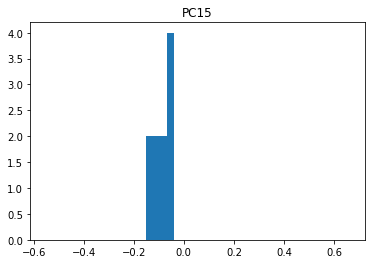

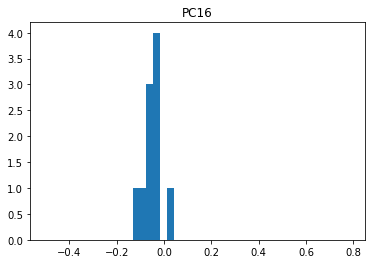

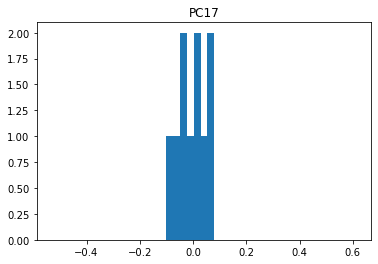

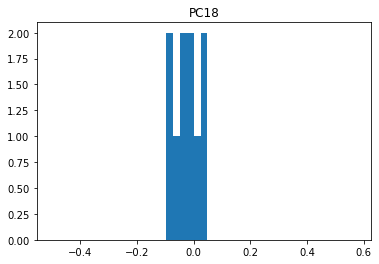

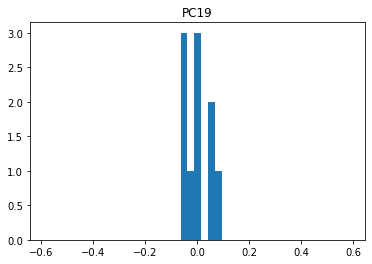

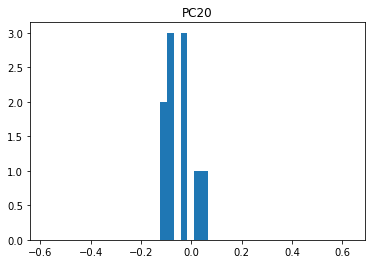

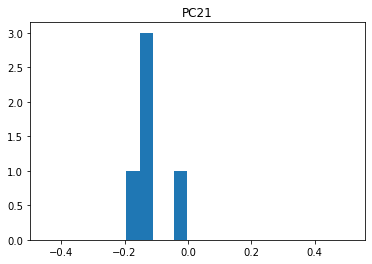

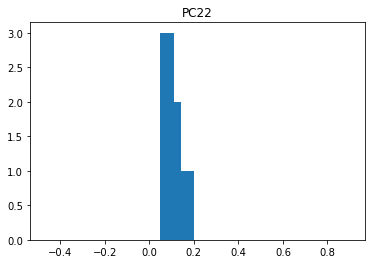

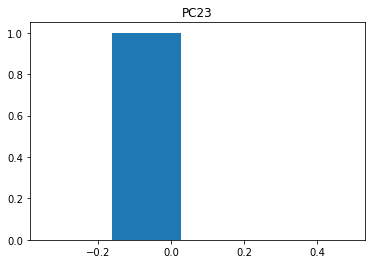

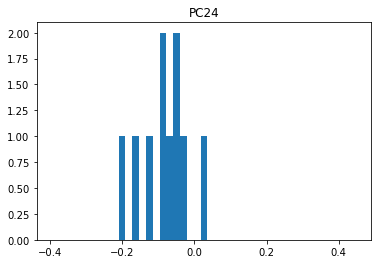

In [10]:
feat_scatter_l = []
for feat in results_df.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(results_df[feat], bins=np.linspace(min_feat, max_feat, 50))
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.show()
    
    feat_scatter = np.std(results_df[feat])
    feat_scatter_l.append(feat_scatter)    

In [11]:
print("Scatter mean:", np.mean(feat_scatter_l))
print("Scatter median:", np.median(feat_scatter_l))
print("Scatter std:", np.std(feat_scatter_l))
print("Scatter max:", np.max(feat_scatter_l))
print("Scatter min:", np.min(feat_scatter_l))

Scatter mean: 0.05074030092914212
Scatter median: 0.049975244222419446
Scatter std: 0.01086311232852437
Scatter max: 0.07502083783490031
Scatter min: 0.03189186960037152


In [82]:
list(np.unique(dataset_bank.index))

['ZTF17aaaacoy',
 'ZTF17aaaacsm',
 'ZTF17aaaadml',
 'ZTF17aaaaemx',
 'ZTF17aaaaene',
 'ZTF17aaaaenu',
 'ZTF17aaaaess',
 'ZTF17aaaaewv',
 'ZTF17aaaankp',
 'ZTF17aaaaxzi',
 'ZTF17aaaayua',
 'ZTF17aaaayzx',
 'ZTF17aaaazhi',
 'ZTF17aaaazkn',
 'ZTF17aaaazmz',
 'ZTF17aaabgbh',
 'ZTF17aaabgbm',
 'ZTF17aaabgby',
 'ZTF17aaabgdz',
 'ZTF17aaabgep',
 'ZTF17aaabghb',
 'ZTF17aaabgil',
 'ZTF17aaabgpy',
 'ZTF17aaabgsl',
 'ZTF17aaabmmo',
 'ZTF17aaabuab',
 'ZTF17aaaccjr',
 'ZTF17aaaccnn',
 'ZTF17aaaceht',
 'ZTF17aaaceyf',
 'ZTF17aaaczhj',
 'ZTF17aaadars',
 'ZTF17aaadasl',
 'ZTF17aaadlcq',
 'ZTF17aaadlhe',
 'ZTF17aaadndc',
 'ZTF17aaadoqi',
 'ZTF17aaadozl',
 'ZTF17aaadpdd',
 'ZTF17aaadpkb',
 'ZTF17aaadpkl',
 'ZTF17aaadpkz',
 'ZTF17aaadqae',
 'ZTF17aaadqdy',
 'ZTF17aaadqyf',
 'ZTF17aaadrbc',
 'ZTF17aaadroa',
 'ZTF17aaadrrq',
 'ZTF17aaaduyi',
 'ZTF17aaaduzw',
 'ZTF17aaadvan',
 'ZTF17aaadvbj',
 'ZTF17aaadvbq',
 'ZTF17aaadvfh',
 'ZTF17aaadvfi',
 'ZTF17aaadvmt',
 'ZTF17aaaegxm',
 'ZTF17aaaehfq',
 'ZTF17aaaehps

In [84]:
%%time

ref_name_l, id_l, dist_l = [], [], []
for ref in list(np.unique(dataset_bank.index)):
    dataset_ref = dataset_bank[dataset_bank.index == ref] 

    feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
    scaled_feat_arr_ref = feat_arr_ref # PCA, so already scaled

    snid = dataset_ref.index.values[0]
    lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
    #lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

    #result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
    result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
    
    ref_name_l.append(snid), id_l.append(result_id), dist_l.append(result_dist)
    
temp_df = pd.DataFrame(zip(ref_name_l, id_l, dist_l), columns=['Reference', 'ids', 'dists'])
temp_df = temp_df.set_index('Reference')
ann_split_df = temp_df.merge(pd.DataFrame(temp_df['ids'].values.tolist()).add_prefix('ann='), on=temp_df.index)
ann_split_df = ann_split_df.set_index('key_0')
ann_dist_all_df = ann_split_df.merge(pd.DataFrame(ann_split_df['dists'].values.tolist()).add_prefix('dist='), on=ann_split_df.index)
ann_dist_all_df = ann_dist_all_df.drop(columns=['ids', 'dists'])
ann_dist_all_df = ann_dist_all_df.set_index('key_0')
ann_dist_all_df

CPU times: user 9min 54s, sys: 3.11 s, total: 9min 57s
Wall time: 10min 3s


,ann=0,ann=1,ann=2,ann=3,ann=4,ann=5,ann=6,ann=7,ann=8,ann=9,dist=0,dist=1,dist=2,dist=3,dist=4,dist=5,dist=6,dist=7,dist=8,dist=9
key_0,,,,,,,,,,,,,,,,,,,,
ZTF17aaaacoy,86647,31494,44394,51539,18892,45597,36962,46621,56870,76025,0.0,0.408542,0.427520,0.441686,0.499101,0.528973,0.564232,0.580511,0.582243,0.593148
ZTF17aaaacsm,6582,66800,37005,39025,70683,1379,16463,19048,89308,69265,0.0,0.458953,0.482770,0.492930,0.523796,0.528795,0.529938,0.530892,0.542349,0.544470
ZTF17aaaadml,42918,76851,36232,27666,79407,32548,61038,65928,75879,45484,0.0,0.505906,0.514876,0.520238,0.521422,0.521685,0.522198,0.550329,0.555622,0.576350
ZTF17aaaaemx,74875,60172,67314,27617,82926,40235,89847,74572,6329,25457,0.0,0.352478,0.422978,0.443602,0.459196,0.460676,0.460821,0.467661,0.468161,0.471162
ZTF17aaaaene,64679,49491,41985,67406,41400,70317,78067,34202,42598,72274,0.0,0.427144,0.443556,0.448340,0.449720,0.451494,0.453022,0.456409,0.456645,0.460210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF22aabfzkg,65477,66408,59045,41637,32683,47701,85977,23580,63845,82937,0.0,0.345764,0.355037,0.357919,0.379959,0.394003,0.410715,0.416296,0.421926,0.424059
ZTF22aabhimn,64034,71825,60647,83310,41016,6553,26049,8397,24116,89187,0.0,0.446109,0.446883,0.511214,0.515074,0.537253,0.544629,0.556114,0.559332,0.565089
ZTF22aabhiwe,64027,52618,29791,15125,55439,21915,35491,47672,63886,67147,0.0,0.343732,0.364002,0.389457,0.397348,0.412020,0.416111,0.419497,0.425573,0.433734


In [85]:
print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df['dist=1']))
print("Scatter median:", np.median(ann_dist_all_df['dist=1']))
print("Scatter std:", np.std(ann_dist_all_df['dist=1']))
print("Scatter max:", np.max(ann_dist_all_df['dist=1']))
print("Scatter min:", np.min(ann_dist_all_df['dist=1']))
print("\n")


# Returns index of max distance
print("Most anomalous (max distance of ref to ANN=1):", ann_dist_all_df[['dist=1']].idxmax().values[0])

summary stats
Scatter mean: 0.5040914699924627
Scatter median: 0.5005940198898315
Scatter std: 0.0964985231853769
Scatter max: 1.3407007455825806
Scatter min: 9.826528184930794e-06


Most anomalous (max distance of ref to ANN=1): ZTF18acbwaxk


# Largest distance

In [86]:
ref_obj = ann_dist_all_df[['dist=1']].idxmax().values[0] #'ZTF18acbwaxk'
print("Dist=1:", ann_dist_all_df.loc[ref_obj]['dist=1']) 

Dist=1: 1.3407007455825806


In [87]:
dataset_bank[dataset_bank.index == ref_obj]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18acbwaxk,-0.175718,1.591882,0.03652,0.95392,1.345966,-0.835704,-0.055619,0.164858,-0.334247,0.818063,...,0.142187,0.290284,-0.313604,0.234499,-0.127187,-0.066337,0.413671,0.968349,0.230589,0.138696


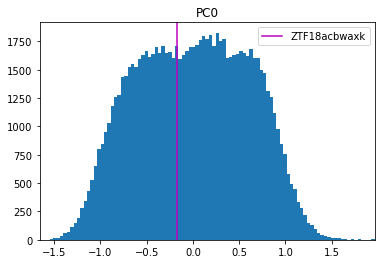

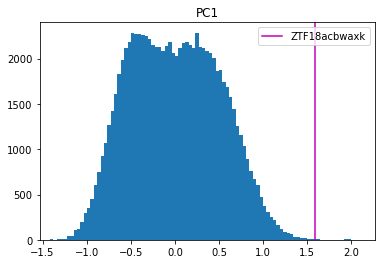

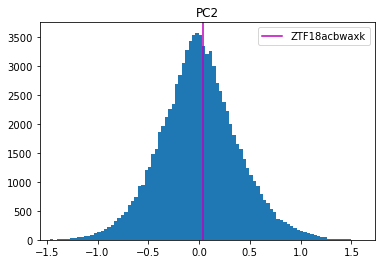

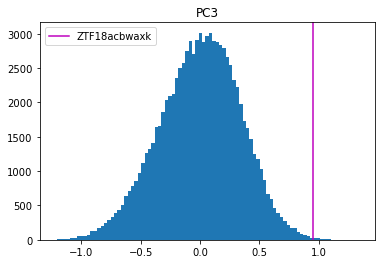

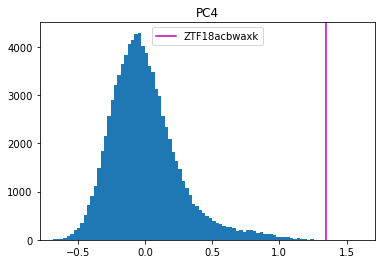

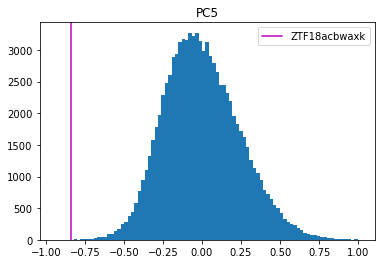

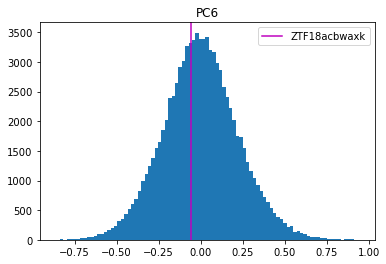

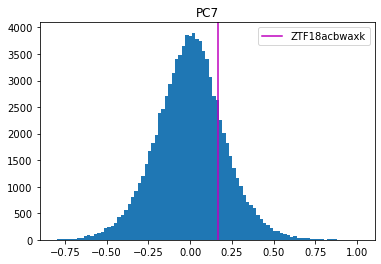

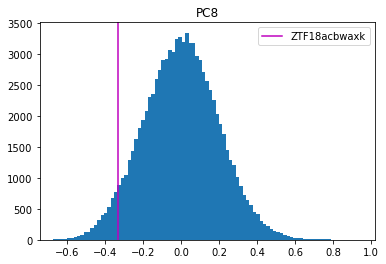

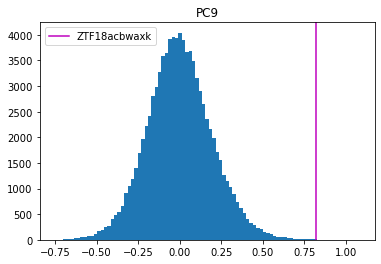

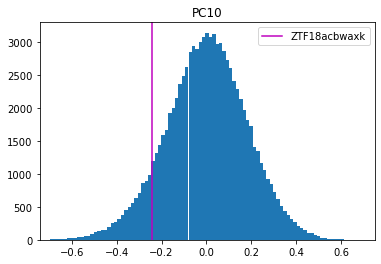

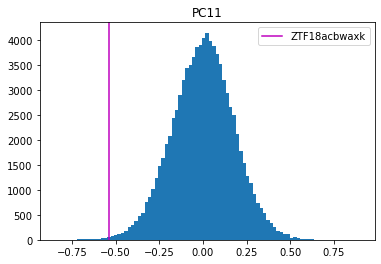

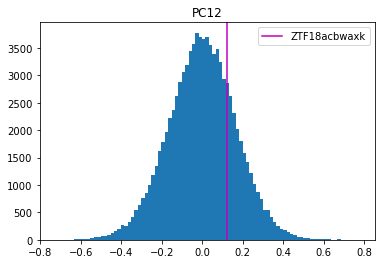

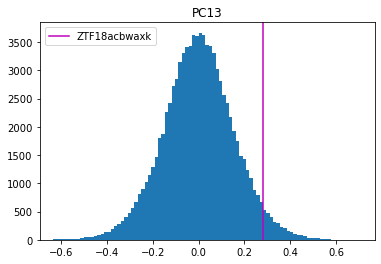

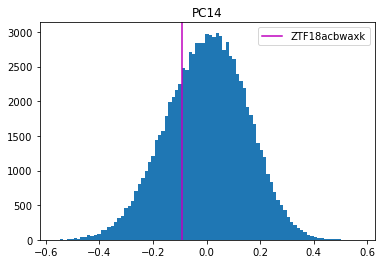

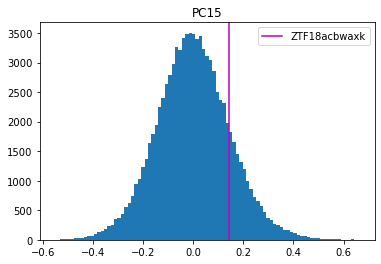

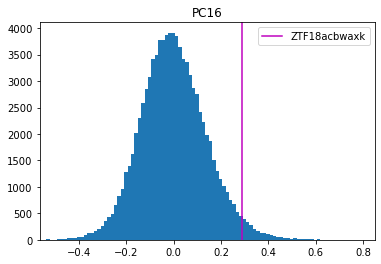

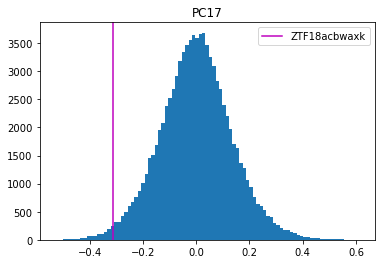

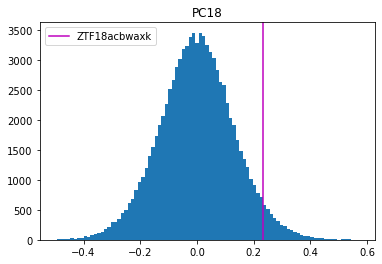

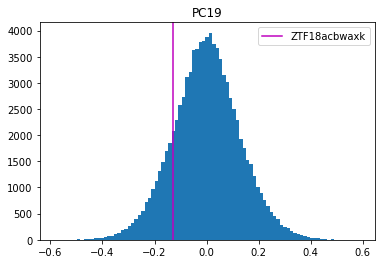

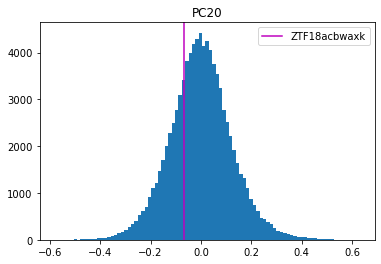

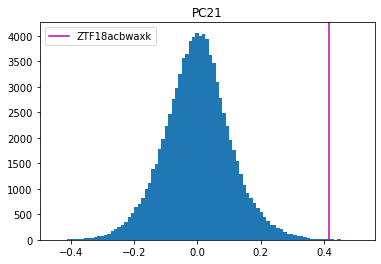

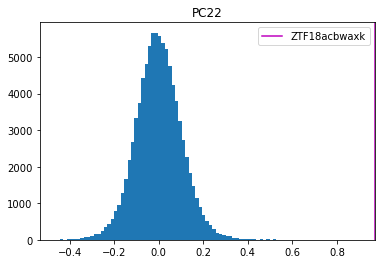

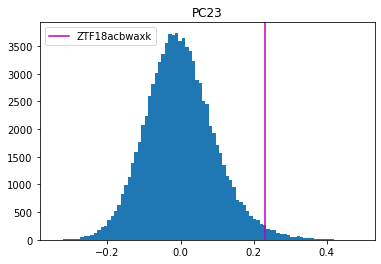

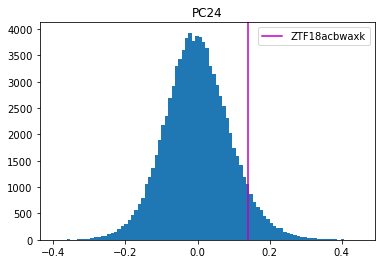

In [88]:
feat_scatter_l = []
for feat in dataset_bank.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(dataset_bank[feat], bins=np.linspace(min_feat, max_feat, 100))
    
    ref = dataset_bank[dataset_bank.index == ref_obj]
    
    ax.axvline(ref[feat].values[0], color='m', label=ref_obj)
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    plt.show()
    
    feat_scatter = np.std(dataset_bank[feat])
    feat_scatter_l.append(feat_scatter)   

In [97]:
dataset_ref = dataset_bank[dataset_bank.index == ref_obj] #  ref_obj

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {snid}") 
link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

[-0.17571842640950372 1.591882327519427 0.03652043481367275
 0.9539201867325255 1.3459660706285943 -0.8357043792801772
 -0.05561921974537642 0.16485808300671115 -0.33424693197860655
 0.8180628018183435 -0.24230388108610199 -0.5374105955259056
 0.12277174531791495 0.2808535623146526 -0.09321436544603727
 0.1421872858784733 0.29028370973852674 -0.3136035511404605
 0.2344985872970094 -0.12718730992472843 -0.06633660835240117
 0.41367102272003536 0.9683485042860486 0.23058881475464238
 0.1386964580035193]
ZTF ID name (ref) ZTF18acbwaxk


https://alerce.online/object/ZTF18acbwaxk

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://alerce.online/object/ZTF18acbwaxk

0		6666				None			0.0


https://alerce.online/object/ZTF20aaynrrh

1		56568				None			1.3407


https://alerce.online/object/ZTF20abqvsik

2		77005				None			1.3818


https://alerce.online/object/ZTF18abusqdv

3		80991				None			1.4035


https://alerce.online/object/ZTF20aammbvq

4		14392				None			1.4714


https://alerce.online/object/ZTF20adadrhw

5		21072				None			1.4796


https://alerce.online/object/ZTF21aaampui

6		45832				None			1.4919


https://alerce.online/object/ZTF19aacgslb

7		11412				None			1.4985


https://alerce.online/object/ZTF20abyyvrw

8		18510				None			1.5043


https://alerce.online/object/ZTF20acxzqyp

9		8134				None			1.5149


In [90]:
# 10 largest ANN=1 distances
ann_dist_all_df['dist=1'].nlargest(10)

key_0
ZTF18acbwaxk    1.340701
ZTF18abcfcoo    1.313559
ZTF20abfehpe    1.296388
ZTF21abbahtb    1.258228
ZTF18aaslagi    1.206757
ZTF18acyyiea    1.175515
ZTF18abusqdv    1.169351
ZTF18abcnbki    1.162389
ZTF20abpdvcy    1.116535
ZTF21aaxntve    1.111943
Name: dist=1, dtype: float64

In [91]:
# 10 largest ANN=1 distances (most different)
for ztfid in list(np.unique(ann_dist_all_df['dist=1'].nlargest(100).index)):
    alerce_link = display_markdown(f'https://alerce.online/object/{ztfid}', raw=True)
    print(alerce_link)

https://alerce.online/object/ZTF17aabowel

None


https://alerce.online/object/ZTF18aaarzgv

None


https://alerce.online/object/ZTF18aabfadv

None


https://alerce.online/object/ZTF18aabjkap

None


https://alerce.online/object/ZTF18aabrxof

None


https://alerce.online/object/ZTF18aanoyin

None


https://alerce.online/object/ZTF18aaoscbs

None


https://alerce.online/object/ZTF18aarwyww

None


https://alerce.online/object/ZTF18aaslagi

None


https://alerce.online/object/ZTF18aavskan

None


https://alerce.online/object/ZTF18aaxuusk

None


https://alerce.online/object/ZTF18abaphqf

None


https://alerce.online/object/ZTF18abbuguo

None


https://alerce.online/object/ZTF18abcfcoo

None


https://alerce.online/object/ZTF18abcnbki

None


https://alerce.online/object/ZTF18abdikoq

None


https://alerce.online/object/ZTF18abftnoh

None


https://alerce.online/object/ZTF18abgjgma

None


https://alerce.online/object/ZTF18abgonyq

None


https://alerce.online/object/ZTF18abieahi

None


https://alerce.online/object/ZTF18abjehxp

None


https://alerce.online/object/ZTF18ablhqle

None


https://alerce.online/object/ZTF18abmjokg

None


https://alerce.online/object/ZTF18abmxabz

None


https://alerce.online/object/ZTF18abmxahs

None


https://alerce.online/object/ZTF18abnbldg

None


https://alerce.online/object/ZTF18abnjsqz

None


https://alerce.online/object/ZTF18abnjusl

None


https://alerce.online/object/ZTF18abnttiu

None


https://alerce.online/object/ZTF18absbgqd

None


https://alerce.online/object/ZTF18abskpxj

None


https://alerce.online/object/ZTF18absolpj

None


https://alerce.online/object/ZTF18abtdcrw

None


https://alerce.online/object/ZTF18abtkeaf

None


https://alerce.online/object/ZTF18abtkfvl

None


https://alerce.online/object/ZTF18abtmtqd

None


https://alerce.online/object/ZTF18abtmxir

None


https://alerce.online/object/ZTF18abtvstb

None


https://alerce.online/object/ZTF18abusqdv

None


https://alerce.online/object/ZTF18abvbbvs

None


https://alerce.online/object/ZTF18abveode

None


https://alerce.online/object/ZTF18abvmjid

None


https://alerce.online/object/ZTF18abvmlow

None


https://alerce.online/object/ZTF18abyslbd

None


https://alerce.online/object/ZTF18abzngtv

None


https://alerce.online/object/ZTF18abzukky

None


https://alerce.online/object/ZTF18acbwaxk

None


https://alerce.online/object/ZTF18acbzyor

None


https://alerce.online/object/ZTF18acdtwxk

None


https://alerce.online/object/ZTF18achekez

None


https://alerce.online/object/ZTF18achruvb

None


https://alerce.online/object/ZTF18acjrwao

None


https://alerce.online/object/ZTF18acszhzt

None


https://alerce.online/object/ZTF18acwdmrn

None


https://alerce.online/object/ZTF18acyyiea

None


https://alerce.online/object/ZTF19aaafeqk

None


https://alerce.online/object/ZTF19aaafovk

None


https://alerce.online/object/ZTF19aadghpt

None


https://alerce.online/object/ZTF19aadnwvc

None


https://alerce.online/object/ZTF19aaeyltm

None


https://alerce.online/object/ZTF19aahsozv

None


https://alerce.online/object/ZTF19aanvjhb

None


https://alerce.online/object/ZTF19aaofigg

None


https://alerce.online/object/ZTF19aapunrg

None


https://alerce.online/object/ZTF19aawsbte

None


https://alerce.online/object/ZTF19aayhstn

None


https://alerce.online/object/ZTF19abagjlk

None


https://alerce.online/object/ZTF19abbzcvs

None


https://alerce.online/object/ZTF19abocnwo

None


https://alerce.online/object/ZTF19abojfes

None


https://alerce.online/object/ZTF19abpmmnj

None


https://alerce.online/object/ZTF19abpqggd

None


https://alerce.online/object/ZTF19abqapbi

None


https://alerce.online/object/ZTF19acekpoy

None


https://alerce.online/object/ZTF19acxfjcy

None


https://alerce.online/object/ZTF20aafcjti

None


https://alerce.online/object/ZTF20aatzhhl

None


https://alerce.online/object/ZTF20aaummaw

None


https://alerce.online/object/ZTF20abeohfn

None


https://alerce.online/object/ZTF20abeywdn

None


https://alerce.online/object/ZTF20abfehpe

None


https://alerce.online/object/ZTF20abijfqq

None


https://alerce.online/object/ZTF20abpdvcy

None


https://alerce.online/object/ZTF20acpdrkt

None


https://alerce.online/object/ZTF20actzmzp

None


https://alerce.online/object/ZTF20acxnstp

None


https://alerce.online/object/ZTF20adadmva

None


https://alerce.online/object/ZTF21aaaadvr

None


https://alerce.online/object/ZTF21aaaqtwd

None


https://alerce.online/object/ZTF21aadriyx

None


https://alerce.online/object/ZTF21aadrmqe

None


https://alerce.online/object/ZTF21aaguiqz

None


https://alerce.online/object/ZTF21aagvmtk

None


https://alerce.online/object/ZTF21aanehlz

None


https://alerce.online/object/ZTF21aangimh

None


https://alerce.online/object/ZTF21aaxntve

None


https://alerce.online/object/ZTF21aaygkfz

None


https://alerce.online/object/ZTF21abbahtb

None


https://alerce.online/object/ZTF21abcgyvu

None


https://alerce.online/object/ZTF21acbalhp

None


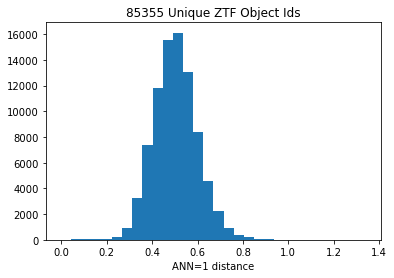

In [100]:
plt.hist(ann_dist_all_df['dist=1'], 
         bins=np.linspace(np.min(ann_dist_all_df['dist=1']), 
                          np.max(ann_dist_all_df['dist=1']), 31), density=False);
plt.xlabel('ANN=1 distance');
#plt.yscale('log')
plt.title(f'{len(ann_dist_all_df)} Unique ZTF Object Ids');

In [101]:
print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df['dist=1']))
print("Scatter median:", np.median(ann_dist_all_df['dist=1']))
print("Scatter std:", np.std(ann_dist_all_df['dist=1']))
print("Scatter max:", np.max(ann_dist_all_df['dist=1']))
print("Scatter min:", np.min(ann_dist_all_df['dist=1']))
print("\n")


# Returns index of max distance
print("Most anomalous (max distance of ref to ANN=1):", ann_dist_all_df[['dist=1']].idxmax().values[0])

summary stats
Scatter mean: 0.5040914699924627
Scatter median: 0.5005940198898315
Scatter std: 0.0964985231853769
Scatter max: 1.3407007455825806
Scatter min: 9.826528184930794e-06


Most anomalous (max distance of ref to ANN=1): ZTF18acbwaxk


# Smallest

In [93]:
np.unique(ann_dist_all_df['dist=1'].nsmallest(10).index)

array(['ZTF18aaocogj', 'ZTF18aaozsqm', 'ZTF18aavjhmu', 'ZTF18aazfgwg',
       'ZTF18abgphmg', 'ZTF18ablwclk', 'ZTF18abnzumw', 'ZTF18abyckld',
       'ZTF18acauvtu', 'ZTF18actyebu'], dtype=object)

In [94]:
# 10 smallest ANN=1 distances (most similar)
for ztfid in list(np.unique(ann_dist_all_df['dist=1'].nsmallest(10).index)):
    alerce_link = display_markdown(f'https://alerce.online/object/{ztfid}', raw=True)
    print(alerce_link)

https://alerce.online/object/ZTF18aaocogj

None


https://alerce.online/object/ZTF18aaozsqm

None


https://alerce.online/object/ZTF18aavjhmu

None


https://alerce.online/object/ZTF18aazfgwg

None


https://alerce.online/object/ZTF18abgphmg

None


https://alerce.online/object/ZTF18ablwclk

None


https://alerce.online/object/ZTF18abnzumw

None


https://alerce.online/object/ZTF18abyckld

None


https://alerce.online/object/ZTF18acauvtu

None


https://alerce.online/object/ZTF18actyebu

None


In [95]:
dataset_ref = dataset_bank[dataset_bank.index == list(np.unique(ann_dist_all_df['dist=1'].nsmallest(10).index))[0]]

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {snid}") 
link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

[1.1460775539951047 0.6019388052420769 0.03182966001167284
 0.6109561910031355 -0.2536579037224312 -0.4767843809224159
 0.045987760050981034 0.08054875212598972 0.1669318514570818
 0.08322330494605387 0.0016831786577276005 -0.22396060258981046
 0.11953331678601134 0.09128471856312165 0.11591925525234761
 0.011650071197843254 0.12166206435213843 0.024661434417433525
 0.0312456953322134 -0.016040507076260813 0.009447865524729928
 0.007121215013812926 0.04951163849352878 0.1255845307677326
 -0.0140457299770083]
ZTF ID name (ref) ZTF18aaocogj


https://alerce.online/object/ZTF18aaocogj

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://alerce.online/object/ZTF18aaocogj

0		10138				None			0.0


https://alerce.online/object/ZTF18aaocogj

1		11308				None			0.008


https://alerce.online/object/ZTF18aamgkvn

2		67418				None			0.3225


https://alerce.online/object/ZTF18abmipiv

3		34498				None			0.3394


https://alerce.online/object/ZTF18aakggdj

4		84291				None			0.3633


https://alerce.online/object/ZTF17aabuoea

5		42124				None			0.3911


https://alerce.online/object/ZTF18abllfmi

6		23963				None			0.3986


https://alerce.online/object/ZTF18aamlbrz

7		52545				None			0.399


https://alerce.online/object/ZTF18abcphfr

8		47968				None			0.4006


https://alerce.online/object/ZTF18abllfmi

9		70719				None			0.4089


MaxAbsScaler, Euclidean, Ia

NON PCA
Scatter mean: 0.10822062189269697
Scatter median: 0.08390001702324312
Scatter std: 0.09273033952967297
Scatter max: 0.3615067063860504
Scatter min: 0.0

PCA
Scatter mean: 0.22748059656595504
Scatter median: 0.23485067052158148
Scatter std: 0.08590310140277316
Scatter max: 0.3552833440373228
Scatter min: 0.013447031738069838

MaxAbsScaler, Euclidean, SLSN

Scatter mean: 0.1882023265906344
Scatter median: 0.14632144856515017
Scatter std: 0.1839875260098897
Scatter max: 1.046586348913336
Scatter min: 0.006225538066605167

MaxAbsScaler, Euclidean, junk

Scatter mean: 0.18480675721201786
Scatter median: 0.14364864210180578
Scatter std: 0.208412667064402
Scatter max: 1.2017613918543555
Scatter min: 0.002740342445819787